From VEST 2020 documentation:

"Election results and precinct shapefile from the NC State Board of Elections (https://www.ncsbe.gov/results-data)

Buncombe 681, Henderson CV, Wake 01-07A, 07-07A are missing from the 20201018 shapefile. They are added from the 20190827 shapefile.

North Carolina produces two sets of election results data. The precinct results are the unaltered results as initially reported by the counties. Many counties report early votes by vote center while provisional and other nonstandard ballots may be reported countywide. The precinct-sorted results are then produced within 30 days after the election. In the precinct-sorted data nearly all votes are assigned to precincts regardless of the manner by which the ballots were cast. However, North Carolina law requires the addition of statistical "noise" to the precinct-sorted data wherever any given vote by any specific voter may otherwise be deduced via cross referencing the various election-related data sets produced by the SBE.

For the 2020 general election 51 counties reported all votes by precinct in their initial precinct results. The precinct-sorted data set was used instead for the counties listed below.

Alleghany, Avery, Beaufort, Bertie*, Bladen, Buncombe, Cabarrus, Caldwell, Camden, Currituck, Dare, Davidson*, Davie, Duplin*, Durham*, Edgecombe, Guilford, Halifax*, Harnett, Haywood, Henderson, Hertford, Hyde, Johnston, Jones, Lee, Lincoln, Macon, Martin, Mecklenburg*, Moore, Nash, New Hanover*, Northampton*, Orange, Pasquotank, Pitt*, Polk, Richmond, Scotland, Stokes*, Surry*, Tyrrell*, Wake, Washington, Watauga, Wayne, Wilkes*, Yadkin

In counties marked by asterisk some votes were still reported by vote center or countywide in the precinct-sorted data. These were distributed by candidate to precincts based on the precinct-level reported vote. The precinct-sorted results were further adjusted to match the certified countywide totals based on the precinct-level vote by candidate."

**2022 RDH Processing:** 

Absentee and voting center votes were allocated proportionally to precincts, by share of precinct-reported vote.

The precinct shapefile available [here](https://www.nconemap.gov/datasets/voting-precincts/explore?location=35.097107%2C-79.888900%2C7.41) was last updated in March of 2023 and therefore has precinct names missing and that do not match the November 2022 election results. After reaching out to the NCSBE, we received the following response which led to all but 5 precinct names matching between the two files:

*I’m not sure which file that site is displaying/making available for download. But I would suggest using this one: https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20220831.zip, as it is the data closest to the Nov 2022 election while also being before the election.*

*We provide shapefiles on our ftp site, which is linked to on our Voting Maps/Redistricting page: https://www.ncsbe.gov/results-data/voting-maps-redistricting*

In [14]:
import pandas as pd
import geopandas as gp
import os
from pdv_functions import *
'''
Sources:
precinct shp: https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20220831.zip
precinct election results: https://www.ncsbe.gov/results-data/election-results/historical-election-results-data
'''

'\nSources:\nprecinct shp: https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20220831.zip\nprecinct election results: https://www.ncsbe.gov/results-data/election-results/historical-election-results-data\n'

In [3]:
#gdf = gp.read_file("./raw-from-source/Voting_Precincts/Voting_Precincts.shp")
gdf = gp.read_file("./raw-from-source/SBE_PRECINCTS_20220831/SBE_PRECINCTS_20220831.shp")
df = pd.read_table("./raw-from-source/results_pct_20221108 (1).zip", sep = "\t")

print("# prec ids in gdf not in df: ",len(set((gdf.county_nam.str.upper()+gdf.prec_id.str.upper()))-set(df.County.str.upper()+df.Precinct.str.upper())))
print("# prec ids in df not in gdf: ", len(set(df.County.str.upper()+df.Precinct.str.upper())-set(gdf.county_nam.str.upper()+gdf.prec_id.str.upper())))
print("shape df: ", (df.County.str.upper()+df.Precinct.str.upper()).nunique(), "\nshape gdf: ", (gdf.county_nam.str.upper()+gdf.prec_id.str.upper()).nunique())

# prec ids in gdf not in df:  0
# prec ids in df not in gdf:  325
shape df:  2977 
shape gdf:  2652


# Process election results

From Ballotpedia:
- To include: US Senate, US House, State Senate, State House, State Supreme Court 
    - 'US SENATE'
    - 'US HOUSE OF REPRESENTATIVES DISTRICT XX'
    - 'NC STATE SENATE DISTRICT XX'
    - 'NC HOUSE OF REPRESENTATIVES DISTRICT XXX'
    - 'NC SUPREME COURT ASSOCIATE JUSTICE SEAT XX'
    
- Not sure: Intermediate Appelate Courts
    - 'NC COURT OF APPEALS JUDGE SEAT XX'
- Not to include: School boards, Municipal government, local ballot measures

## Grab info for column dictionaries

In [5]:
#Set party col
potential_party = df['Choice Party']
party_dict = {'DEM':'D','LIB':'L','REP':'R','UNA':'U','GRE':'G', "na":"N"}
df["col_party"] = df.loc[df['Choice Party'].isin(party_dict.keys()), "Choice Party"].map(party_dict)
df.loc[df["col_party"].isna(), 'col_party'] = "N"


#Set last name abrv - will need to edit 
df["col_last_name"] = "na"
df.loc[df["Choice"].str.contains(". "), "col_last_name"] = df["Choice"].str.split(pat=" ").str[2].str.slice(stop=3).str.upper()
df.loc[df["col_last_name"].isna(), "col_last_name"] = df["Choice"].str.split(pat=" ").str[1].str.slice(stop=3).str.upper()
df.loc[df["Choice"] == "Write-In (Miscellaneous)", "col_last_name"] = "OWR"


#Set contest
general_office_dict = {"US SENATE":"USS", "US HOUSE": "CON", "STATE SENATE":"SU", "NC HOUSE OF REPRESENTATIVES": "SL", 
                       "NC SUPREME COURT": "SSC", "NC COURT OF APPEALS JUDGE":"IA"}
df["col_office"]='na'
df.loc[(df["Contest Name"].str.contains("US SENATE")), "col_office"] = "US SENATE"
df.loc[(df["Contest Name"].str.contains("US HOUSE")), "col_office"] = "US HOUSE"
df.loc[(df["Contest Name"].str.contains("STATE SENATE")), "col_office"] = "STATE SENATE"
df.loc[(df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES")), "col_office"] = "NC HOUSE OF REPRESENTATIVES"
df.loc[(df["Contest Name"].str.contains("NC SUPREME COURT")), "col_office"] = "NC SUPREME COURT"
df.loc[(df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE")), "col_office"] = "NC COURT OF APPEALS JUDGE"
df["office_abr"] = df["col_office"].map(general_office_dict)


#Set districts
#Get CONG DIST
df["col_cong_dist"] = "na"
df.loc[df["Contest Name"].str.contains("US HOUSE"), "col_cong_dist"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET state sen dist
df["col_su_dist"] = "na"
df.loc[df["Contest Name"].str.contains("STATE SENATE"), "col_su_dist"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET state house dist
df["col_sl_dist"] = "na"
df.loc[df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES"), "col_sl_dist"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET ssc seat
df["col_ssc_seat"] = "na"
df.loc[df["Contest Name"].str.contains("NC SUPREME COURT"), "col_ssc_seat"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET court of appeals dist
df["col_ia_seat"] = "na"
df.loc[df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE"), "col_ia_seat"] = df["Contest Name"].str.split(pat=" ").str[-1]


#Create column names
df["full_col_names"] = "na"
#cong
df.loc[df["Contest Name"].str.contains("US HOUSE"), "full_col_names"] = "G" + df["office_abr"] + df['col_cong_dist'] + df['col_party'] + df['col_last_name']
#us sen
df.loc[df["Contest Name"].str.contains("US SENATE"), "full_col_names"] = "G22" + df["office_abr"] + df['col_party'] + df['col_last_name']
#state sen
df.loc[df["Contest Name"].str.contains("STATE SENATE"), "full_col_names"] = "G" + df["office_abr"] + df['col_su_dist'].str.zfill(2) + df['col_party'] + df['col_last_name']
#state house
df.loc[df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES"), "full_col_names"] = "G" + df["office_abr"] + df['col_sl_dist'].str.zfill(3) + df['col_party'] + df['col_last_name']
#state ssc
df.loc[df["Contest Name"].str.contains("NC SUPREME COURT"), "full_col_names"] = "G22" + df["office_abr"] + df["col_ssc_seat"].str.zfill(2) + df['col_last_name']
#IA court
df.loc[df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE"), "full_col_names"] = "G22" + df["office_abr"] + df["col_ia_seat"].str.zfill(2) + df['col_last_name']


#filter
df = df[~df["office_abr"].isna()]

## Pivot

In [6]:
## PIVOT RESULTS
df_pivot = df.pivot_table(index = ['County','Precinct'],
                         columns = ['full_col_names'],
                        values = ['Total Votes'],
                         aggfunc = 'sum')


#Clean up the indices
df_pivot.reset_index(inplace = True,drop=False)
df_pivot[('County', 'County')] = df_pivot[('County', '')]
df_pivot[('Precinct', 'Precinct')] = df_pivot[('Precinct', '')]


#Rename the columns
df_pivot.columns = df_pivot.columns.map(pd.Series([col[1] for col in df_pivot.columns], index = [col for col in df_pivot.columns]).to_dict())
df_pivot = df_pivot.fillna(0)


df_pivot["UNIQUE_ID"] = df_pivot["County"] + "---" + df_pivot["Precinct"]

In [7]:
df_pivot

,,,G22IA08FLO,G22IA08THO,G22IA09SAL,G22IA09STR,G22IA10ADA,G22IA10TYS,G22IA11JAC,G22IA11STA,...,GSU47RHIS,GSU48DCAR,GSU48RMOF,GSU49DMAY,GSU49RAND,GSU50DMCC,GSU50RCOR,County,Precinct,UNIQUE_ID
0,ALAMANCE,01,1733.0,397.0,377.0,1757.0,396.0,1738.0,395.0,1735.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMANCE,01,ALAMANCE---01
1,ALAMANCE,02,1918.0,401.0,392.0,1925.0,404.0,1916.0,395.0,1923.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMANCE,02,ALAMANCE---02
2,ALAMANCE,035,1230.0,855.0,829.0,1256.0,861.0,1222.0,857.0,1227.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMANCE,035,ALAMANCE---035
3,ALAMANCE,03C,961.0,665.0,622.0,1004.0,657.0,964.0,646.0,975.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMANCE,03C,ALAMANCE---03C
4,ALAMANCE,03N,922.0,742.0,716.0,955.0,729.0,935.0,738.0,922.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ALAMANCE,03N,ALAMANCE---03N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,YANCEY,07 BRU,181.0,87.0,81.0,186.0,83.0,185.0,83.0,185.0,...,188.0,0.0,0.0,0.0,0.0,0.0,0.0,YANCEY,07 BRU,YANCEY---07 BRU
2973,YANCEY,08 CRA,1084.0,454.0,449.0,1092.0,447.0,1089.0,454.0,1084.0,...,1178.0,0.0,0.0,0.0,0.0,0.0,0.0,YANCEY,08 CRA,YANCEY---08 CRA
2974,YANCEY,09 SOU,718.0,613.0,584.0,746.0,601.0,727.0,611.0,719.0,...,796.0,0.0,0.0,0.0,0.0,0.0,0.0,YANCEY,09 SOU,YANCEY---09 SOU
2975,YANCEY,10 PEN,250.0,100.0,98.0,253.0,99.0,250.0,97.0,254.0,...,269.0,0.0,0.0,0.0,0.0,0.0,0.0,YANCEY,10 PEN,YANCEY---10 PEN


## Re-allocate absentee votes
For write in, assign last name = OWR

In [8]:
searchfor = ['ABS', 'PROVISIONAL','PROVISIOINAL','PROVI ','PROV',
             'ONE STOP','ONESTOP','OS ','OS-',' OS','OSAP','OSCA',
             'OSCH','OSKD','OSLL','OSLOB','OSNR','OSOP','OSTA','OSWA',
             'OSDU','-OS','OSAV','OSBOE','OSGR','OSHS','OSJB','OSSE','OSWD',
             'OSCS','OSHT','MAOS','DBOS',
             'CURBSIDE','TRANS','LEE COUNTY BOE' 
            ]
in_sos =  df_pivot[df_pivot["Precinct"].str.contains('|'.join(searchfor))]
in_sos = in_sos.groupby(by=["County"]).sum().reset_index()
in_sos

,County,G22IA08FLO,G22IA08THO,G22IA09SAL,G22IA09STR,G22IA10ADA,G22IA10TYS,G22IA11JAC,G22IA11STA,G22SSC03DIE,...,GSU45RPRO,GSU46DMAR,GSU46RDAN,GSU47RHIS,GSU48DCAR,GSU48RMOF,GSU49DMAY,GSU49RAND,GSU50DMCC,GSU50RCOR
0,ALLEGHANY,2199.0,967.0,889.0,2283.0,949.0,2206.0,936.0,2204.0,2221.0,...,0.0,0.0,0.0,2413.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AVERY,1533.0,759.0,731.0,1563.0,756.0,1531.0,750.0,1536.0,1531.0,...,0.0,0.0,0.0,1663.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BEAUFORT,6158.0,3829.0,3656.0,6362.0,3793.0,6203.0,3779.0,6183.0,6289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BERTIE,1267.0,2073.0,2101.0,1292.0,2106.0,1275.0,2099.0,1275.0,1316.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BLADEN,3508.0,3218.0,3148.0,3577.0,3156.0,3547.0,3143.0,3493.0,3545.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BUNCOMBE,22790.0,46789.0,44971.0,24560.0,46556.0,22969.0,46563.0,22899.0,23425.0,...,0.0,12271.0,7699.0,0.0,0.0,0.0,34541.0,15146.0,0.0,0.0
6,CABARRUS,18023.0,18115.0,17478.0,18712.0,18096.0,18044.0,17914.0,18162.0,18148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,CALDWELL,12803.0,4428.0,4282.0,12975.0,4413.0,12818.0,4425.0,12784.0,12860.0,...,10301.0,0.0,0.0,3339.0,0.0,0.0,0.0,0.0,0.0,0.0
8,CAMDEN,1542.0,654.0,609.0,1597.0,646.0,1557.0,627.0,1566.0,1574.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,CASWELL,308.0,171.0,161.0,319.0,165.0,313.0,171.0,310.0,311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
election_results = df_pivot[~df_pivot["Precinct"].str.contains('|'.join(searchfor))]
election_results = allocate_absentee(election_results,in_sos,df_pivot.columns[df_pivot.columns.str.startswith("G")],'County')
print('Done')

Done


In [10]:
election_results

,,,,,G22IA08FLO,G22IA08THO,G22IA09SAL,G22IA09STR,G22IA10ADA,G22IA10TYS,...,GSU47RHIS,GSU48DCAR,GSU48RMOF,GSU49DMAY,GSU49RAND,GSU50DMCC,GSU50RCOR,County,Precinct,UNIQUE_ID
0,ALAMANCE,01,ALAMANCE,01,1733,397,377,1757,396,1738,...,0,0,0,0,0,0,0,ALAMANCE,01,ALAMANCE---01
1,ALAMANCE,02,ALAMANCE,02,1918,401,392,1925,404,1916,...,0,0,0,0,0,0,0,ALAMANCE,02,ALAMANCE---02
2,ALAMANCE,035,ALAMANCE,035,1230,855,829,1256,861,1222,...,0,0,0,0,0,0,0,ALAMANCE,035,ALAMANCE---035
3,ALAMANCE,03C,ALAMANCE,03C,961,665,622,1004,657,964,...,0,0,0,0,0,0,0,ALAMANCE,03C,ALAMANCE---03C
4,ALAMANCE,03N,ALAMANCE,03N,922,742,716,955,729,935,...,0,0,0,0,0,0,0,ALAMANCE,03N,ALAMANCE---03N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,YANCEY,07 BRU,YANCEY,07 BRU,181,87,81,186,83,185,...,188,0,0,0,0,0,0,YANCEY,07 BRU,YANCEY---07 BRU
2973,YANCEY,08 CRA,YANCEY,08 CRA,1084,454,449,1092,447,1089,...,1178,0,0,0,0,0,0,YANCEY,08 CRA,YANCEY---08 CRA
2974,YANCEY,09 SOU,YANCEY,09 SOU,718,613,584,746,601,727,...,796,0,0,0,0,0,0,YANCEY,09 SOU,YANCEY---09 SOU
2975,YANCEY,10 PEN,YANCEY,10 PEN,250,100,98,253,99,250,...,269,0,0,0,0,0,0,YANCEY,10 PEN,YANCEY---10 PEN


# GDF

<AxesSubplot:>

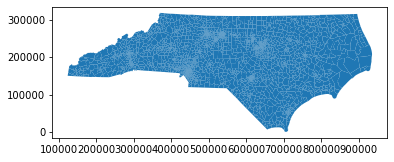

In [73]:
assert gdf['geometry'].isna().any()==False
gdf.plot()

## Merge precinct boundaries with precinct election results

In [11]:
set(df_pivot['County']) - set(gdf['county_nam'])

set()

In [13]:
merge_attempt2 = pd.merge(gdf, election_results.fillna(value=0), left_on=['county_nam','prec_id'], right_on=["County","Precinct"], how='outer', indicator=True)
export_attempt2 = merge_attempt2[merge_attempt2['_merge']!='both']
export_attempt2[['county_nam', 'prec_id', 'enr_desc', 'of_prec_id', 'County', 'Precinct', '_merge']].to_csv('./merge_attempt2.csv')


'''
	county_nam	prec_id	enr_desc	of_prec_id	County	Precinct	_merge
2248	CASWELL	PROVI	PROVIDENCE				left_only
2652					HENDERSON	CV	right_only
2653					LEE	MCSWAIN CENTER	right_only
2654					WAKE	01-07A	right_only
2655					WAKE	07-07A	right_only


'''

'\n\tcounty_nam\tprec_id\tenr_desc\tof_prec_id\tCounty\tPrecinct\t_merge\n2248\tCASWELL\tPROVI\tPROVIDENCE\t\t\t\tleft_only\n2652\t\t\t\t\tHENDERSON\tCV\tright_only\n2653\t\t\t\t\tLEE\tMCSWAIN CENTER\tright_only\n2654\t\t\t\t\tWAKE\t01-07A\tright_only\n2655\t\t\t\t\tWAKE\t07-07A\tright_only\n\n\n'

In [76]:
pgdf = merge_attempt2[merge_attempt2['_merge']=='both']
#compare state totals df with pgdf
#compare precint sums with county sums from df to pgdf
#response pending from NCSBE about precinct names that do not match back up

In [81]:
pgdf['_merge'].isna().any()

False